The training data include 2 classes: [1 2]


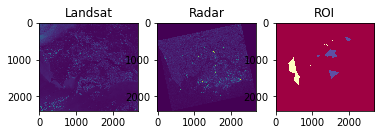

[ 0.22446653  0.36895044  0.19784416  0.13113385  0.07760502]
0.99180211728
             precision    recall  f1-score   support

          1       1.00      0.99      0.99     24767
          2       0.99      1.00      0.99     24636

avg / total       0.99      0.99      0.99     49403

[[24480   287]
 [  118 24518]]


In [3]:
import skimage.io as io
from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics, cross_validation
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.externals import joblib

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

# read training samples as TIF with same dimensions as the Landsat image
samples1 = '/Users/yjiang/Documents/pythonWorkspace/treemap/Data/training/non-palm.tif'
samples2 = '/Users/yjiang/Documents/pythonWorkspace/treemap/Data/training/palm.tif'
roi_ds_1 = io.imread(samples1)
roi_1 = np.array(roi_ds_1, dtype='uint8')
roi_ds_2 = io.imread(samples2)
roi_2 = np.array(roi_ds_2, dtype='uint8')
roi = roi_1 + roi_2

labels = np.unique(roi[roi > 0])
print('The training data include {n} classes: {classes}'.format(n=labels.size, classes=labels))

# read landsat image
def read(path):  
    img_ds = gdal.Open(path, gdal.GA_ReadOnly)
    img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
                   gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
    for b in range(img.shape[2]):
        img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()
    return img

def array_to_raster(array, output_path, ref_path):    
    Image = gdal.Open(ref_path, gdal.GA_ReadOnly)     

    Output = gdal.GetDriverByName('GTiff').Create(output_path, Image.RasterXSize, Image.RasterYSize, 1, gdal.GDT_Float32, options=['COMPRESS=DEFLATE'])
    Output.SetProjection(Image.GetProjectionRef())
    Output.SetGeoTransform(Image.GetGeoTransform()) 
    Output.GetRasterBand(1).WriteArray(array)
    Output.FlushCache()  # Write to disk.

landsat_path = '/Users/yjiang/Documents/pythonWorkspace/treemap/Data/landsat_clip.tif'
radar_path = '/Users/yjiang/Documents/pythonWorkspace/treemap/Data/radar_clip.tif'
landsat = read(landsat_path)
radar = read(radar_path)
img = np.dstack((landsat, radar[:,:,0]))
# img = landsat

# Display them
plt.subplot(131)
plt.imshow(landsat[:, :, 1])
plt.title('Landsat')

plt.subplot(132)
plt.imshow(radar[:, :, 1])
plt.title('Radar')

plt.subplot(133)
plt.imshow(roi, cmap=plt.cm.Spectral)
plt.title('ROI')

plt.show()

# pairing X and y
rows = img.shape[0]
cols = img.shape[1]
band_num = img.shape[2]

# create mask image
mask_landsat = np.zeros((rows, cols))
mask_landsat[~np.isnan(landsat[:, :, 1])] = 1

mask_radar = np.zeros((rows, cols))
mask_radar[radar[:, :, 1]>0] = 1

mask = mask_landsat*mask_radar

# handle missing value
img[np.isnan(img)] = 0
X = img[roi > 0, :]
y = roi[roi > 0]

# split data into traing and testing (accuracy will be evaluated on testing only)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
# train a model, Set the parameters by cross-validation and gridsearch
rf = RandomForestClassifier(n_estimators=80, max_depth=20)
predicted = cross_validation.cross_val_predict(rf, X_train, y_train, cv=5)
model = rf.fit(X, y)
print(rf.feature_importances_)

predicted = model.predict(X_test)
print(metrics.accuracy_score(y_test, predicted))
print(metrics.classification_report(y_test, predicted))
print(metrics.confusion_matrix(y_test, predicted))

# now you can save it to a file
model_path = '/Users/yjiang/Documents/pythonWorkspace/treemap/Data/model_radar_1.joblib'
joblib.dump(rf, model_path) 
# and later you can load it
# model = joblib.load(model_path)

# making prediction, save and print the output
predict = model.predict(img.reshape(cols*rows, band_num))
output = predict.reshape(rows, cols)*mask

plt.imshow(output, cmap=plt.cm.Spectral)
path = '/Users/yjiang/Documents/pythonWorkspace/treemap/Data/classification.tif'
# io.imsave(path, output)
array_to_raster(output, path, landsat_path)